# OBJECTIVE, PROBLEM AND DATA
<b>Objective:</b> To learn Logistic Regression involving multiple classes
* Classification
* Cost Function
* Learn to use scikit-learn library for regression
* Understanding of loss function and its gradient
* Overfitting and Regularization
* Using scikit-learn library to do MultiClassRegression
<b>Problem:</b> We will solve two set of problems

<b>Data</b>

The MNIST problem is a dataset developed by Yann LeCun, Corinna Cortes and Christopher Burges for evaluating machine learning models on the handwritten digit classification problem. The dataset was constructed from a number of scanned document dataset available from the National Institute of Standards and Technology (NIST). This is where the name for the dataset comes from, as the Modified NIST or MNIST dataset. Images of digits were taken from a variety of scanned documents, normalized in size and centered. This makes it an excellent dataset for evaluating models, allowing the developer to focus on the machine learning with very little data cleaning or preparation required. Each image is a 28 by 28 pixel square (784 pixels total). A standard spit of the dataset is used to evaluate and compare models, where 60,000 images are used to train a model and a separate set of 10,000 images are used to test it. It is a digit recognition task. As such there are 10 digits (0 to 9) or 10 classes to predict. 

<b>Problem</b>
The task is to classify the handwritten images into 10 different categories.
<img src="./images/mlc.jpg">

<b>Excercise</b>
1. Run the code
2. Check the texts, formulae in the comments
3. Try hyperparameter tuning (regularization, solver, penalty)
4. Currently the data is split into training and test set. Cosider splitting the data into training, test and validation set. Use hyperparameter tuning with the test set and do model validation using the validation set. 
5. Try to improve the accuracy of the prediciton.

In [1]:
import scipy.io
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.special import expit
from keras.datasets import mnist

Using TensorFlow backend.


Sigmoid Activation Function
sigmoid(t)=$\frac{1}{1+e^{-t}}$

<img src="./images/sigmoid.png" style="float: left; margin-right: 10px;" />

In [2]:
def sigmoid(t):
    g = np.zeros(t.shape)
    g = expit(t)
    return g

Try plotting the sigmoid function by synethsizing your own data.

In [3]:
def displayData(X, example_width=None):
    m,n = X.shape
    plt.figure(figsize=(16,16))
    if X.ndim == 1:
        X = np.reshape(X, (-1,m))
    if not example_width or not 'example_width' in locals():
        example_width = int(round(math.sqrt(X.shape[1])))
    #plt.set_cmap("gray")
    example_height = n / example_width
    display_rows = int(math.floor(math.sqrt(m)))
    display_cols = int(math.ceil(m / display_rows))
    pad = 1
    display_array = -np.ones((pad + display_rows * int(example_height + pad),  pad + display_cols * int(example_width + pad)))
    curr_ex = 1
    for j in range(1,display_rows+1):
        for i in range (1,display_cols+1):
            if curr_ex > m:
                break
            max_val = max(abs(X[curr_ex-1, :]))
            rows = pad + (j - 1) * (int(example_height) + pad) + np.array(range(int(example_height)))
            cols = pad + (i - 1) * (int(example_width)  + pad) + np.array(range(int(example_width)))
            display_array[rows[0]:rows[-1]+1 , cols[0]:cols[-1]+1] = np.reshape(X[curr_ex-1, :], (int(example_height), int(example_width)), order="F") / max_val
            curr_ex += 1
            if curr_ex > m:
                break
    h = plt.imshow(display_array.T, vmin=-1, vmax=1)
    plt.axis('off')
    plt.show(block=False)
    return h, display_array

# Simplified Cost Function, its Gradient and Regularization

We cannot use the same cost function that we used for linear regression because the Logistic Function will cause the output to be wavy, causing many local minima. In other words, it will not be a convex function.

Instead, our cost function for logistic regression looks like:

$J(\theta)=\frac{1}{m}Cost(h_{\theta}(x^{(i)}),y^{(i)})$

$Cost(h_{\theta}(x),y)=-log(h_{\theta}(x))$ if $y=1$

$Cost(h_{\theta}(x),y)=-log(1-h_{\theta}(x))$ if $y=0$

$Cost(h_{\theta}(x),y)=0$ if $h_{\theta}(x)=y$

$Cost(h_{\theta}(x),y) \rightarrow \infty$ if $y=0$ and $h_{\theta}(x) \rightarrow 1$

$Cost(h_{\theta}(x),y) \rightarrow \infty$ if $y=1$ and $h_{\theta}(x) \rightarrow 0$
<img src=./images/logreg_cf.jpg> If our correct answer $y$ is 0, then the cost function will be 0 if our hypothesis function also outputs 0. If our hypothesis approaches 1, then the cost function will approach infinity.

If our correct answer $y$ is 1, then the cost function will be 0 if our hypothesis function outputs 1. If our hypothesis approaches 0, then the cost function will approach infinity.

Note that writing the cost function in this way guarantees that $J(\theta)$ is convex for logistic regression.

<b>Cost function</b>

$J(\theta)=-\frac{1}{m} \Sigma_{i=1}^{m}[y^{(i)}log(h_{\theta}(x^{(i)})) + (1-y^{(i)})log(1-h_{\theta}(x^{(i)}))]+\frac{\lambda}{2m}\theta^{2}$

<b>Cost function in vectorized form</b>

$h=\sigma(X\theta)$

$J(\theta)=-\frac{1}{m}(y^{T}log(h)+(1-y)^{T}log(1-h))+\frac{\lambda}{2m}\theta^{2}$

<b>Gradient</b>

$\nabla_{\theta}J(\theta)=\frac{1}{m}X^{T}(h-y)+\frac{\lambda}{m}\theta$

Graident descent can be implemented using the following expression.
$\theta:=\theta-\frac{\alpha}{m}X^{T}(h-y)$

However, we will used an inbuilt function (fmin or fmin_bgfs from the scipy.optimize package) for finding the optimal parameters $\theta$.

Lastly the point to note is that there are additional terms $\frac{\lambda}{2m}\theta^{2}$ and $\frac{\lambda}{m}\theta$ added to the cost fucntion and its derivative. These terms result from regularization which is used to prevent overfitting of the data. Bigger value of $\lambda$ will prevent overfitting.

In [4]:
def costFunction(theta, X, y, lambda_reg, return_grad=False):
    m = len(y)
    J = 0
    grad = np.zeros(theta.shape)
    one = y * np.transpose(np.log( sigmoid( np.dot(X,theta) ) ))
    two = (1-y) * np.transpose(np.log( 1 - sigmoid( np.dot(X,theta) ) ))
    reg = ( float(lambda_reg) / (2*m)) * np.power(theta[1:theta.shape[0]],2).sum()
    J = -(1./m)*(one+two).sum() + reg
    grad = (1./m) * np.dot(sigmoid( np.dot(X,theta) ).T - y, X).T + ( float(lambda_reg) / m )*theta
    grad_no_regularization = (1./m) * np.dot(sigmoid( np.dot(X,theta) ).T - y, X).T
    grad[0] = grad_no_regularization[0]
    if return_grad == True:
        return J, grad.flatten()
    elif return_grad == False:
        return J

Multiclass regression as 1 vs All: A regression problems consisting of multiple class can be reduced to a binary classification problem. For example the classification of handwritten digits into 10 classes  (0,1...,8,9) can be done first by first considering 0 as one class and non zero as another class, then 1 as one class and non 1 as another and so on.    
<img src="./images/mlc.jpg">

In [5]:
def oneVsAll(X, y, num_labels, lambda_reg):
    m, n = X.shape
    all_theta = np.zeros((num_labels, n + 1))
    X = np.column_stack((np.ones((m,1)), X))
    for c in range(num_labels):
        initial_theta = np.zeros((n + 1, 1))
        myargs = (X, (y%10==c).astype(int), lambda_reg, True)
        theta = minimize(costFunction, x0=initial_theta, args=myargs, options={'disp': True, 'maxiter':12}, method="Newton-CG", jac=True)
        all_theta[c,:] = theta["x"]
    return all_theta

In [6]:
def predictOneVsAll(all_theta, X):
    m = X.shape[0]
    num_labels = all_theta.shape[0]
    p = np.zeros((m, 1))
    X = np.column_stack((np.ones((m,1)), X))
    p = np.argmax(sigmoid( np.dot(X,all_theta.T) ), axis=1)
    return p

# Training, Test and Validation Set
* Training set is used for training the model. 
* Test Set is used for hyperparameter tuning.
* Validation Set is used for model validation.

Load the digits and the labels. The loaded data is split into training and test sets.

In [7]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 8s 1us/step


In [8]:
# building the input vector from the 28x28 pixels
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

The pixel values range from 0 to 255: the background majority close to 0, and those close to 255 representing the digit.
Normalizing the input data helps to speed up the training.

In [9]:
# normalizing the data to help with the training
X_train /= 255
X_test /= 255

In [10]:
# print the final input shape ready for training
print("Train matrix shape", X_train.shape)
print("Test matrix shape", X_test.shape)
print(np.unique(y_train, return_counts=True))

Train matrix shape (60000, 784)
Test matrix shape (10000, 784)
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))


In [11]:
n_classes = 10
input_layer_size = 784
num_labels = n_classes
X=X_train
y=y_train


Let's inspect a few examples. The MNIST dataset contains only grayscale images. For more advanced datasets, we'll have the three color channels (RGB).

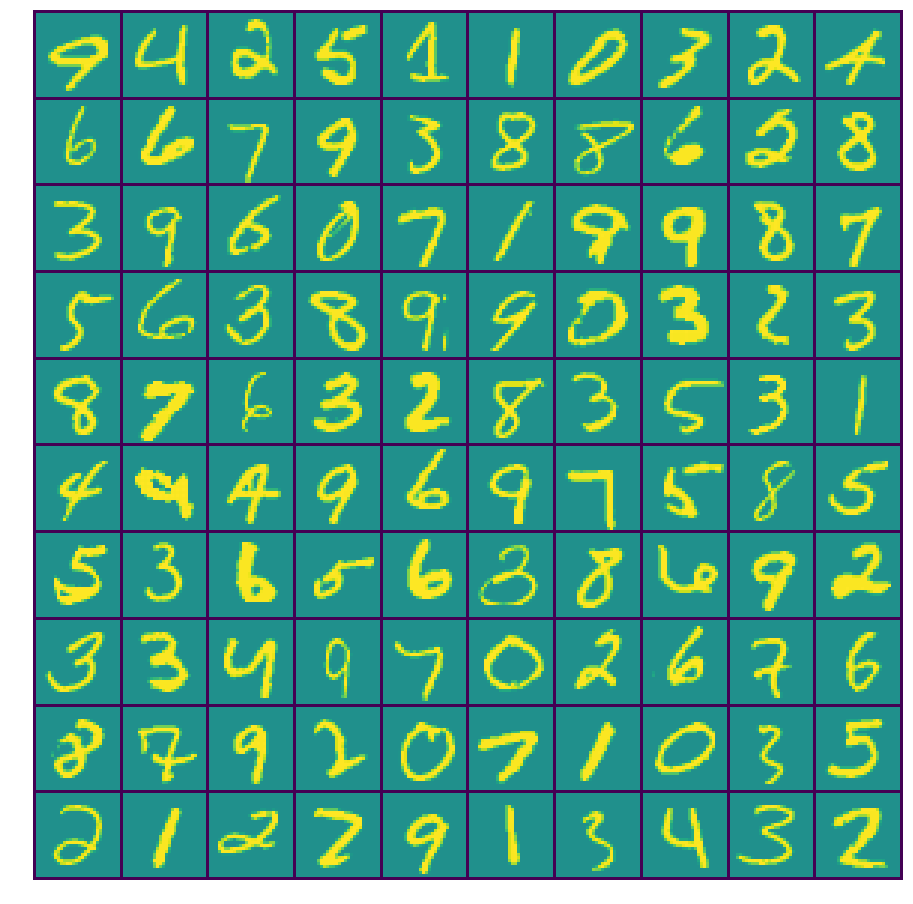

In [12]:
m,n=X.shape
#y=y.flatten()
rand_indices = np.random.permutation(m)
random_images = X[rand_indices[:100],:]
displayData(random_images)
lambda_reg = 0.1

In [13]:
all_theta = oneVsAll(X, y, num_labels, lambda_reg)

         Current function value: 0.020740
         Iterations: 12
         Function evaluations: 13
         Gradient evaluations: 274
         Hessian evaluations: 0
         Current function value: 0.023679
         Iterations: 12
         Function evaluations: 13
         Gradient evaluations: 196
         Hessian evaluations: 0
         Current function value: 0.062641
         Iterations: 12
         Function evaluations: 14
         Gradient evaluations: 245
         Hessian evaluations: 0
         Current function value: 0.076428
         Iterations: 12
         Function evaluations: 13
         Gradient evaluations: 228
         Hessian evaluations: 0
         Current function value: 0.046024
         Iterations: 12
         Function evaluations: 13
         Gradient evaluations: 348
         Hessian evaluations: 0
         Current function value: 0.087229
         Iterations: 12
         Function evaluations: 14
         Gradient evaluations: 201
         Hessian evaluations: 

In [14]:
pred = predictOneVsAll(all_theta, X_train)
print('Training Set Accuracy: {:f}'.format((np.mean(pred == y_train%10)*100)))
print('Training Set Accuracy for 1:  {:f}'.format(np.mean(pred[500:1000]  == y.flatten()[500:1000]%10)  * 100))
print('Training Set Accuracy for 2:  {:f}'.format(np.mean(pred[1000:1500] == y.flatten()[1000:1500]%10) * 100))
print('Training Set Accuracy for 3:  {:f}'.format(np.mean(pred[1500:2000] == y.flatten()[1500:2000]%10) * 100))
print('Training Set Accuracy for 4:  {:f}'.format(np.mean(pred[2000:2500] == y.flatten()[2000:2500]%10) * 100))
print('Training Set Accuracy for 5:  {:f}'.format(np.mean(pred[2500:3000] == y.flatten()[2500:3000]%10) * 100))
print('Training Set Accuracy for 6:  {:f}'.format(np.mean(pred[3000:3500] == y.flatten()[3000:3500]%10) * 100))
print('Training Set Accuracy for 7:  {:f}'.format(np.mean(pred[3500:4000] == y.flatten()[3500:4000]%10) * 100))
print('Training Set Accuracy for 8:  {:f}'.format(np.mean(pred[4000:4500] == y.flatten()[4000:4500]%10) * 100))
print('Training Set Accuracy for 9:  {:f}'.format(np.mean(pred[4500:5000] == y.flatten()[4500:5000]%10) * 100))
print('Training Set Accuracy for 0: {:f}'.format(np.mean(pred[0:500]     == y.flatten()[0:500]%10)     * 100))

Training Set Accuracy: 92.415000
Training Set Accuracy for 1:  92.000000
Training Set Accuracy for 2:  88.200000
Training Set Accuracy for 3:  94.400000
Training Set Accuracy for 4:  94.000000
Training Set Accuracy for 5:  93.600000
Training Set Accuracy for 6:  93.200000
Training Set Accuracy for 7:  94.000000
Training Set Accuracy for 8:  92.200000
Training Set Accuracy for 9:  94.200000
Training Set Accuracy for 0: 94.200000


In [15]:
#Write the code to test the 'Test Set Accuracy'

In [16]:
#Randomize all the digits
rand_indices = np.random.permutation(m)
random_X = X[rand_indices[:m],:]
random_y = y[rand_indices[:m]]

Input the index of the random image you want to predict 14
Predicted digit  [1]
Actual digit  1


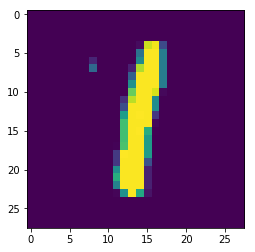

In [17]:
num_digit=int(input("Input the index of the random image you want to predict "))
pred1=predictOneVsAll(all_theta, random_X[num_digit,:].reshape(1,-1))
print("Predicted digit ", pred1)
print("Actual digit ",random_y[num_digit])
plt.imshow((random_X[num_digit,:].reshape(28,28)))
plt.show()

In [18]:
displayData(theta0);

NameError: name 'theta0' is not defined

# Using Scikit-Learn library 

In [ ]:
from scipy.optimize import minimize
from scipy.special import expit
from sklearn import linear_model

In [ ]:
logreg = linear_model.LogisticRegression(C=10., multi_class='multinomial', penalty='l2', solver='newton-cg', tol=0.1)
logreg.fit(X, y);

In [ ]:
pred = logreg.predict(X);
print('Training Set Accuracy: {:f}'.format((np.mean(pred == y%10)*100)));
print('Training Set Accuracy for 1:  {:f}'.format(np.mean(pred[500:1000]  == y.flatten()[500:1000]%10)  * 100));
print('Training Set Accuracy for 2:  {:f}'.format(np.mean(pred[1000:1500] == y.flatten()[1000:1500]%10) * 100));
print('Training Set Accuracy for 3:  {:f}'.format(np.mean(pred[1500:2000] == y.flatten()[1500:2000]%10) * 100));
print('Training Set Accuracy for 4:  {:f}'.format(np.mean(pred[2000:2500] == y.flatten()[2000:2500]%10) * 100));
print('Training Set Accuracy for 5:  {:f}'.format(np.mean(pred[2500:3000] == y.flatten()[2500:3000]%10) * 100));
print('Training Set Accuracy for 6:  {:f}'.format(np.mean(pred[3000:3500] == y.flatten()[3000:3500]%10) * 100));
print('Training Set Accuracy for 7:  {:f}'.format(np.mean(pred[3500:4000] == y.flatten()[3500:4000]%10) * 100));
print('Training Set Accuracy for 8:  {:f}'.format(np.mean(pred[4000:4500] == y.flatten()[4000:4500]%10) * 100));
print('Training Set Accuracy for 9:  {:f}'.format(np.mean(pred[4500:5000] == y.flatten()[4500:5000]%10) * 100));
print('Training Set Accuracy for 10: {:f}'.format(np.mean(pred[0:500]     == y.flatten()[0:500]%10)     * 100));

In [ ]:
#Write the code to test the 'Test Set Accuracy'

In [ ]:
coef = logreg.coef_.copy()
displayData(coef);